In [3]:
import os

# List current directory files
print("Files in the current directory:", os.listdir("/content"))


Files in the current directory: ['.config', 'sample_data']


In [4]:
import os

# Create the Kaggle directory
os.makedirs("/root/.kaggle", exist_ok=True)

# Move the kaggle.json file to the Kaggle directory
!mv kaggle.json /root/.kaggle/

# Set permissions
!chmod 600 /root/.kaggle/kaggle.json

print("✅ Kaggle credentials configured successfully!")


mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
✅ Kaggle credentials configured successfully!


In [5]:
import kagglehub

# Download the dataset
path = kagglehub.dataset_download("sot2542/coffee-bean-dataset-v1")

print("✅ Dataset downloaded successfully!")
print("📁 Path to dataset:", path)


100%|██████████| 9.53G/9.53G [01:11<00:00, 143MB/s]

Extracting files...


✅ Dataset downloaded successfully!
📁 Path to dataset: /root/.cache/kagglehub/datasets/sot2542/coffee-bean-dataset-v1/versions/1


In [6]:
import os

# Define the dataset path
dataset_path = "/root/.cache/kagglehub/datasets/sot2542/coffee-bean-dataset-v1/versions/1"

# Check the dataset contents
print("✅ Dataset Path:", dataset_path)
print("\n📁 Contents of the Dataset:")
print(os.listdir(dataset_path))


✅ Dataset Path: /root/.cache/kagglehub/datasets/sot2542/coffee-bean-dataset-v1/versions/1

📁 Contents of the Dataset:
['data_image_png_3024x3024']


In [7]:
# Locate the image folder
image_dir = os.path.join(dataset_path, "data_image_png_3024x3024")

# Verify the contents of the image folder
print("\n📁 Contents of Image Folder:", os.listdir(image_dir))



📁 Contents of Image Folder: ['coffee_dataset']


In [8]:
# Check the coffee_dataset contents
coffee_dir = os.path.join(image_dir, "coffee_dataset")

# Display the contents
print("\n📁 Contents of 'coffee_dataset':", os.listdir(coffee_dir))



📁 Contents of 'coffee_dataset': ['train', 'test']


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


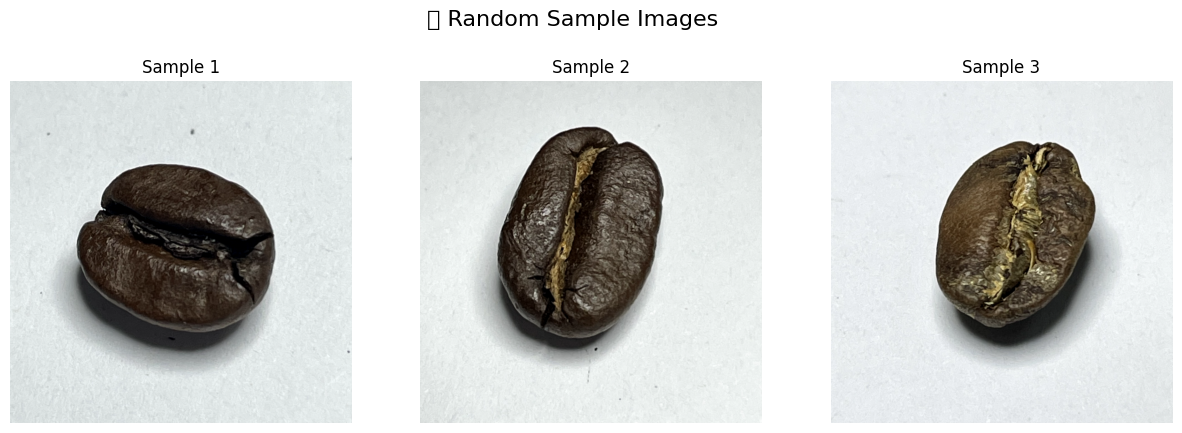

In [9]:
import cv2
import matplotlib.pyplot as plt
import random

# Paths to training and testing directories
train_dir = os.path.join(coffee_dir, "train")
test_dir = os.path.join(coffee_dir, "test")

# Get all image files from the training set
image_files = []
for root, _, files in os.walk(train_dir):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_files.append(os.path.join(root, file))

# Display 3 random images
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle("🔥 Random Sample Images", fontsize=16)

for i in range(3):
    img_file = random.choice(image_files)
    img = cv2.imread(img_file)

    if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB for display
        axes[i].imshow(img)
        axes[i].set_title(f"Sample {i+1}")
        axes[i].axis("off")
    else:
        axes[i].text(0.5, 0.5, "Invalid Image", ha="center", va="center", fontsize=12)
        axes[i].axis("off")

plt.show()


In [10]:
import tensorflow as tf

# Define the batch size
BATCH_SIZE = 32
IMG_SIZE = (256, 256)

# Create dataset pipelines
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    label_mode='int',        # Use integer labels for sparse categorical loss
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42
)

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode='int',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

# Display dataset info
print("\n✅ Dataset Pipelines Created!")
print(f"👉 Train dataset: {len(train_dataset)} batches")
print(f"👉 Validation dataset: {len(val_dataset)} batches")


Found 1200 files belonging to 4 classes.
Found 400 files belonging to 4 classes.

✅ Dataset Pipelines Created!
👉 Train dataset: 38 batches
👉 Validation dataset: 13 batches


In [11]:
# Normalize and cache the datasets
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = (
    train_dataset
    .map(lambda x, y: (x / 255.0, y))    # Normalize pixel values
    .cache()
    .shuffle(1000)
    .prefetch(buffer_size=AUTOTUNE)
)

val_dataset = (
    val_dataset
    .map(lambda x, y: (x / 255.0, y))    # Normalize pixel values
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

print("\n✅ Datasets normalized and cached!")



✅ Datasets normalized and cached!


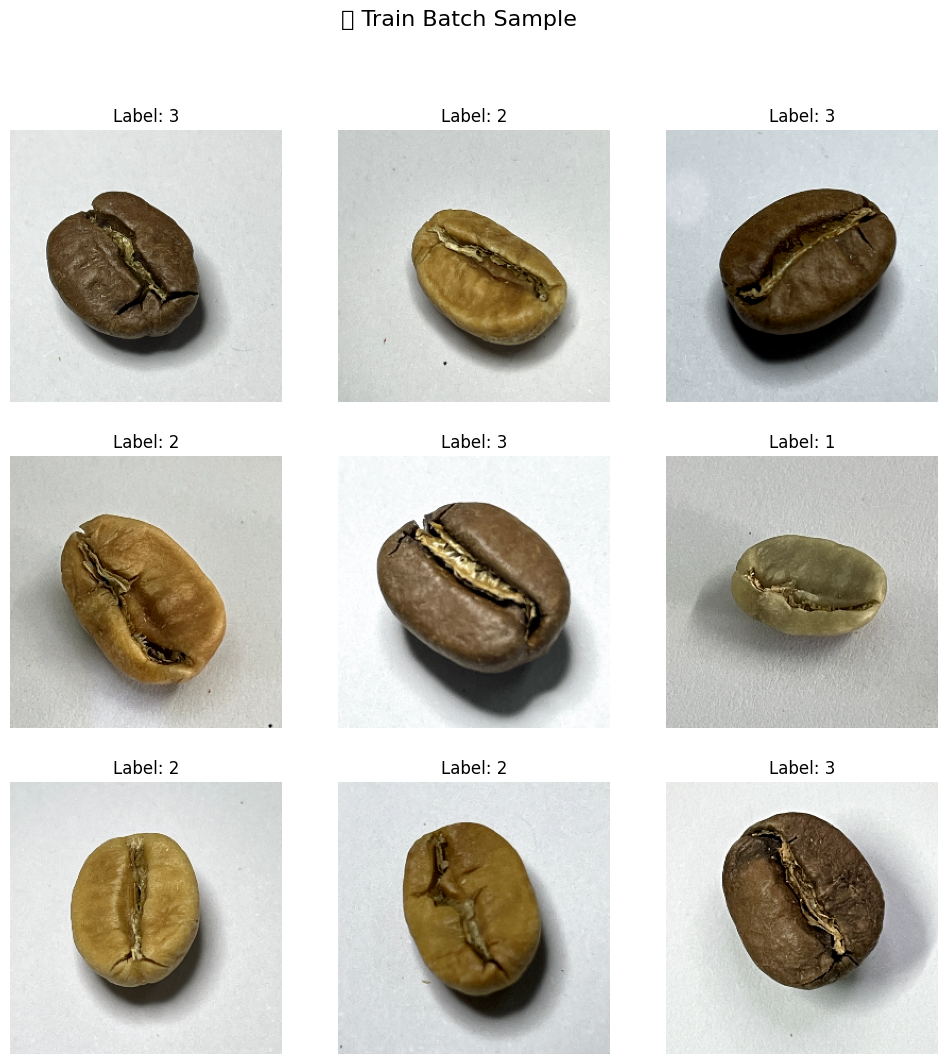

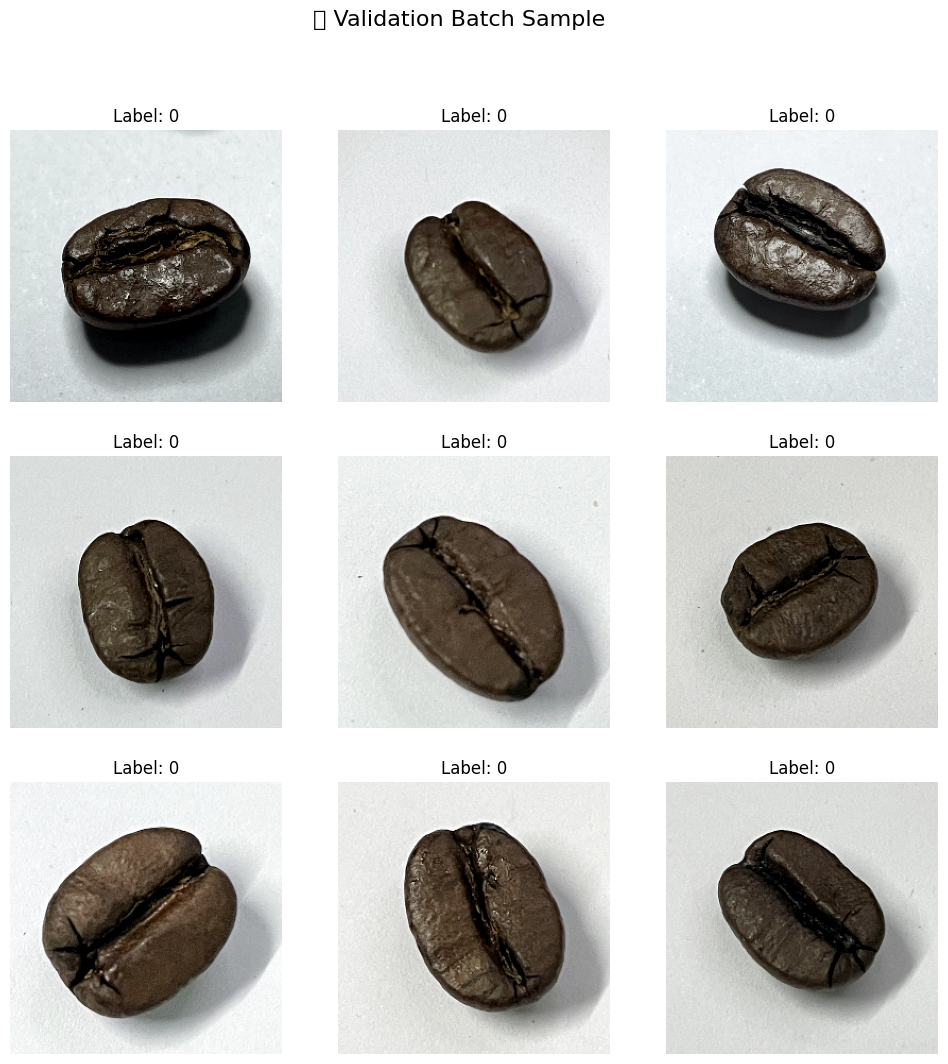

In [12]:
import matplotlib.pyplot as plt

# Display a batch of images
def display_batch(dataset, title="Batch Sample"):
    plt.figure(figsize=(12, 12))
    for images, labels in dataset.take(1):
        for i in range(9):
            plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy())
            plt.title(f"Label: {labels[i].numpy()}")
            plt.axis("off")
    plt.suptitle(title, fontsize=16)
    plt.show()

# Display samples from train and validation datasets
display_batch(train_dataset, "🔥 Train Batch Sample")
display_batch(val_dataset, "🔥 Validation Batch Sample")


In [13]:
from tensorflow.keras import layers, models

# Define the model
model = models.Sequential()

# ✅ Add the Input Layer with Shape Definition
model.add(layers.Input(shape=(256, 256, 3)))   # Define input shape

# Data Augmentation
model.add(layers.RandomFlip("horizontal_and_vertical"))
model.add(layers.RandomRotation(0.2))
model.add(layers.RandomZoom(0.2))

# Convolutional Layers
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Flatten the feature maps
model.add(layers.Flatten())

# Dense Layers
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.4))  # Prevent overfitting
model.add(layers.Dense(4, activation='softmax'))  # 4 classes

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Model summary
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)             │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation (RandomRotation)     │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom (RandomZoom)             │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 115200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      29,491,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,585,732 (112.86 MB)

 Trainable params: 29,585,732 (112.86 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=25,                # You can increase if needed
    batch_size=32,            # Ensure batch size is appropriate for your hardware
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only=True)
    ]
)


Epoch 1/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.3281 - loss: 3.4149

38/38 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.3319 - loss: 3.3728 - val_accuracy: 0.6925 - val_loss: 0.6326
Epoch 2/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.8382 - loss: 0.4214

38/38 ━━━━━━━━━━━━━━━━━━━━ 55s 232ms/step - accuracy: 0.8390 - loss: 0.4194 - val_accuracy: 0.9225 - val_loss: 0.1885
Epoch 3/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9409 - loss: 0.1780

38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - accuracy: 0.9407 - loss: 0.1781 - val_accuracy: 0.9650 - val_loss: 0.0986
Epoch 4/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.9612 - loss: 0.1211 - val_accuracy: 0.9200 - val_loss: 0.2459
Epoch 5/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.9393 - loss: 0.1533 - val_accuracy: 0.9275 - val_loss: 0.1967
Epoch 6/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.9458 - loss: 0.1342 - val_accuracy: 0.9525 - val_loss: 0.1367
Epoch 7/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.9648 - loss: 0.1094 - val_accuracy: 0.9425 - val_loss: 0.1542
Epoch 8/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9531 - loss: 0.1397

38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 224ms/step - accuracy: 0.9532 - loss: 0.1392 - val_accuracy: 0.9600 - val_loss: 0.0934
Epoch 9/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.9412 - loss: 0.1730 - val_accuracy: 0.9600 - val_loss: 0.1094
Epoch 10/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9813 - loss: 0.0810

38/38 ━━━━━━━━━━━━━━━━━━━━ 12s 275ms/step - accuracy: 0.9811 - loss: 0.0813 - val_accuracy: 0.9750 - val_loss: 0.0745
Epoch 11/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.9588 - loss: 0.1109 - val_accuracy: 0.9325 - val_loss: 0.2024
Epoch 12/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.9708 - loss: 0.0651 - val_accuracy: 0.9725 - val_loss: 0.0852
Epoch 13/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.9764 - loss: 0.0758 - val_accuracy: 0.9650 - val_loss: 0.0873
Epoch 14/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 0.9747 - loss: 0.0633 - val_accuracy: 0.9575 - val_loss: 0.1391
Epoch 15/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.9622 - loss: 0.1108 - val_accuracy: 0.9475 - val_loss: 0.1674


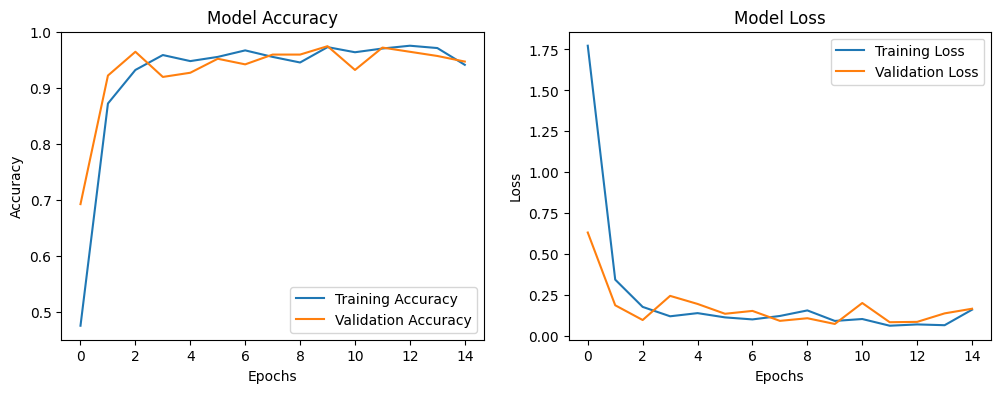

In [15]:
import matplotlib.pyplot as plt

# Plot accuracy and loss
def plot_metrics(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Accuracy plot
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.legend()

    # Loss plot
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.set_title('Model Loss')
    ax2.legend()

    plt.show()

# Call the function
plot_metrics(history)


In [16]:
# Evaluate the model
loss, accuracy = model.evaluate(val_dataset)
print(f"✅ Model Evaluation - Loss: {loss}, Accuracy: {accuracy}")


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9767 - loss: 0.0791
✅ Model Evaluation - Loss: 0.0745132640004158, Accuracy: 0.9750000238418579


In [18]:
# Save the trained model
model.save("coffee_bean_classifier.h5")


In [19]:
# Save the model in the recommended Keras format
model.save("coffee_bean_classifier.keras")
